In [1]:
import numpy as np

### Setting up the data

The image is in the format: batch_size, width, height, colors

The filter is: width, height, in_colors, out_colors

In [2]:
# dimensions of the image
batch_size, dim_x, dim_y, colors=2, 10, 11, 5

# dimensions of the filter
kernel_x, kernel_y, in_colors, out_colors=2, 3, colors, 4

In [3]:
# using random numbers to fill the image and the weights
im=np.random.rand(batch_size, dim_x, dim_y, colors)
weights=np.random.rand(kernel_x, kernel_y, in_colors, out_colors)

### Defining a convolution operation

In [4]:
def convolve(im, weights):
    
    # get the dimensions of image and kernel
    kernel_x, kernel_y, in_colors, out_colors=weights.shape
    batch_size, dim_x, dim_y, colors=im.shape
    
    # allocate an output array
    # the batch_size stays the same, the number of colors is specified in the shape of the filter
    # but the x and y dimensions of the output need to be calculated
    # the formula is:
    # out_x = in_x - filter_x +1
    out=np.empty((batch_size, dim_x-kernel_x+1, dim_y-kernel_y+1, out_colors))
    
    # look at every coordinate in the output
    for i in range(out.shape[1]):
        for j in range(out.shape[2]):
            
            # at this location, slice a rectangle out of the input image
            # the batch_size and the colors are retained
            # crop has the shape: batch_size, kernel_x, kernel_y, in_colors
            crop=im[:,i:i+kernel_x, j:j+kernel_y]
            
            # the values in crop will be multiplied by the weights
            # look how the shapes match:
            # crop:   batch_size, x, y, in_colors
            # weights:            x, y, in_colors, out_colors
            
            # numpy can broadcast this, but ONLY if an extra dimension is added to crop
            # crop now has the shape: batch_size, x, y, in_colors, 1
            crop=np.expand_dims(crop, axis=-1)
            
            # numpy broadcast magic
            # in parallel along the batch_size
            # matches the x, y and in_colors dimensions and multiplies them pairwise
            res=crop*weights
            
            # res has the shape: batch_size, x, y, in_colors, out_colors
            # we want to sum along x, y, and in_colors
            # those are the dimensions 1, 2, 3
            # we want to keep the batch_size and the out_colors
            res=np.apply_over_axes(np.sum, res, [1,2,3]).reshape(batch_size,-1)
            
            out[:,i,j]=res
            
    return out

### Apply

Use the new convolve function to compute the output of the convolution.
Calculate an output value which will be used to test the backward pass later on.

In [5]:
out=convolve(im, weights)

In [6]:
# set up a random weight for every entry in the output
debug_weights=np.random.rand(*out.shape)

# multiply the output with the random weights, reduce it by summing everything
# This scalar output value depends on every entry in the output
# If you change an entry, the output value will change with the random weight
# therefore, it is possible to identify which value in the output has changed
debug_out=np.sum(out*debug_weights)

In [7]:
debug_out

2472.7945262736876

### Backward pass

The backward pass is a convolution with weights that are:
1. mirrored along the x axis
2. mirrored along the y axis
3. transposed: in_colors and out_colors are switched

This convolution has to be performed in a padded output.
The gradients (output of this convolution) need to match the shape of the input.
By applying the convolution, the x and y dimensions are reduced by (kernel_x-1) and (kernel_y-1) respectively.

Before applying the convolution for the backward pass, the output will be padded with 2(kernel_x-1).

In [8]:
out_shape=out.shape

# set up an array for the padded output
padded=np.zeros((batch_size, out_shape[1]+2*(kernel_x-1), out_shape[2]+2*(kernel_y-1), out_colors))

# copy the output to its center
padded[:, kernel_x-1:kernel_x-1+out_shape[1], kernel_y-1:kernel_y-1+out_shape[2]]=debug_weights

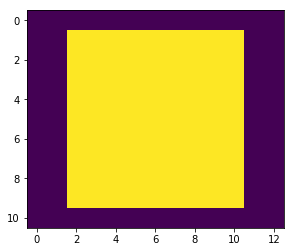

In [15]:
# plotting the padded output.

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow((padded[0]>0).sum(axis=-1))

In [11]:
# the weights for the backward pass have to be adap
backward_weights=weights[::-1,::-1].transpose((0,1,3,2))

In [12]:
grads=convolve(padded, backward_weights)

In [13]:
grads.shape

(2, 10, 11, 5)

In [14]:
eps=1e-4
tol=1e-8

for idx in np.ndindex(im.shape):
    
    d_im=im.copy()
    d_im[idx]+=eps
    d_out=convolve(d_im, weights)
    d_debug_out=np.sum(d_out*debug_weights)

    grad=(d_debug_out-debug_out)/eps
    
    assert np.abs(grad-grads[idx])<tol, idx